# Bidirectional Sentiment Analysis of Financial News Headlines with an Attention Mechanism

### Imports

In [15]:
import pandas as pd
import seaborn as sb
import re
import gensim
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from attention import Attention
from keras.optimizers import Adam
from keras import backend as K
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

### Loading the Dataset

In [16]:
df = pd.read_csv("./Datasets/SentimentData.csv")

### Data Visualisation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5847 non-null   object
 1   Sentiment  5847 non-null   object
dtypes: object(2)
memory usage: 91.5+ KB
None


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

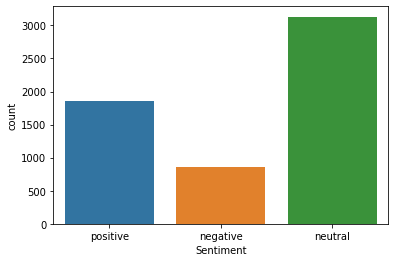

In [17]:
print(df.info())
sb.countplot(x="Sentiment", data=df)

### Data Preprocessing

In [18]:
sentences = df["Sentence"].apply(gensim.utils.simple_preprocess)
print(sentences.head())

0    [the, geosolutions, technology, will, leverage...
1     [esi, on, lows, down, to, bk, real, possibility]
2    [for, the, last, quarter, of, componenta, net,...
3    [according, to, the, finnish, russian, chamber...
4    [the, swedish, buyout, firm, has, sold, its, r...
Name: Sentence, dtype: object


### Denominate Sentiment Values

In [19]:
labels = df["Sentiment"].copy()

for i in range(labels.shape[0]):
    if (df["Sentiment"].iloc[i] == "positive"):
        labels.iloc[i] = 0
    elif (df["Sentiment"].iloc[i] == "neutral"):
        labels.iloc[i] = 1
    elif (df["Sentiment"].iloc[i] == "negative"):
        labels.iloc[i] = 2
        
print(labels[:5])

0    0
1    2
2    0
3    1
4    1
Name: Sentiment, dtype: object


### Word to Vector Transformation

In [20]:
word2vecModel = gensim.models.Word2Vec(window=10, min_count=2, workers=4)
word2vecModel.build_vocab(sentences, progress_per=1000)
word2vecModel.train(sentences, total_examples=word2vecModel.corpus_count, epochs=100)

(7293667, 10166600)

### Embedding and Padding

In [21]:
maxLength = 0

for sentence in sentences:
    if (len(sentence) > maxLength):
        maxLength = len(sentence)

X = []
y = []

for i in range(sentences.shape[0]):
    sentence = sentences[i]
    wordVec = []
    # Embedding
    for word in sentence:
        if (word in word2vecModel.wv):
            wordVec.append(word2vecModel.wv[word].tolist())
    # Padding
    for j in range(maxLength-len(wordVec)):
        wordVec.append([0 for index in range(100)])
    X.append(wordVec)
    y.append(labels[i])
    
X = np.array(X)
y = np.array(y)
X = X.astype(np.float32)
y = y.astype(np.float32)

print(X.shape)
print(X.dtype)
print(y.shape)
print(y.dtype)

(5847, 50, 100)
float32
(5847,)
float32


### One Hot Encoding

In [22]:
y_hot = to_categorical(y)

### Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.1, random_state=42, shuffle=False)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5262, 50, 100)
(5262, 3)
(585, 50, 100)
(585, 3)


### Define Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 50, 64)           34048     
 nal)                                                            
                                                                 
 attention_1 (Attention)     (None, 32)                8192      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 42,339
Trainable params: 42,339
Non-trainable params: 0
_________________________________________________________________
None


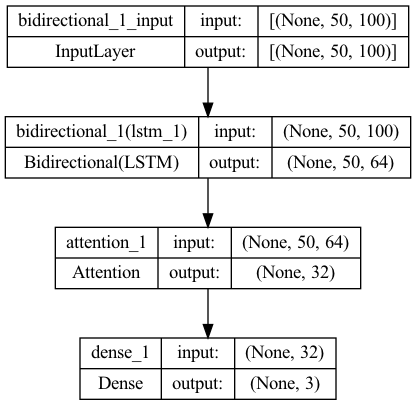

In [24]:
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Attention(units=32))
model.add(Dense(3, activation='sigmoid'))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['acc'])
print(model.summary())
plot_model(model, to_file='./SentimentBidirectionalAttentionModel.png', show_shapes=True)

### Train Model

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=10, verbose=1)

Epoch 1/10


2022-08-18 19:35:05.363539: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


329/329 [==============================] - ETA: 0s - loss: 0.7397 - acc: 0.6784

2022-08-18 19:35:21.484255: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


329/329 [==============================] - 24s 46ms/step - loss: 0.7397 - acc: 0.6784 - val_loss: 0.6883 - val_acc: 0.6906
Epoch 2/10
329/329 [==============================] - 12s 38ms/step - loss: 0.5701 - acc: 0.7522 - val_loss: 0.6919 - val_acc: 0.6769
Epoch 3/10
329/329 [==============================] - 13s 39ms/step - loss: 0.4883 - acc: 0.7866 - val_loss: 0.6764 - val_acc: 0.7094
Epoch 4/10
329/329 [==============================] - 13s 39ms/step - loss: 0.4286 - acc: 0.8024 - val_loss: 0.6832 - val_acc: 0.6872
Epoch 5/10
329/329 [==============================] - 11s 34ms/step - loss: 0.3826 - acc: 0.8259 - val_loss: 0.6922 - val_acc: 0.7145
Epoch 6/10
329/329 [==============================] - 11s 34ms/step - loss: 0.3481 - acc: 0.8381 - val_loss: 0.7828 - val_acc: 0.7060
Epoch 7/10
329/329 [==============================] - 11s 32ms/step - loss: 0.3127 - acc: 0.8504 - val_loss: 0.8351 - val_acc: 0.7179
Epoch 8/10
329/329 [==============================] - 10s 30ms/step - los

### Predict on Test Data

In [26]:
y_hat = model.predict(X_test)

2022-08-18 19:37:04.073770: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


19/19 [==============================] - 1s 10ms/step


### Decode Prediction

In [27]:
yHatAbsolute = []
yHatText = []

for i in range(len(y_hat)):
    maxConfidenceScore = 0
    indexOfMaxScore = 0
    prediction = y_hat[i]
    for j in range(len(prediction)):
        if (prediction[j] > maxConfidenceScore):
            maxConfidenceScore = prediction[j]
            indexOfMaxScore = j
    if (indexOfMaxScore == 0):
        yHatAbsolute.append([1, 0, 0])
        yHatText.append("positive")
    elif (indexOfMaxScore == 1):
        yHatAbsolute.append([0, 1, 0])
        yHatText.append("neutral")
    elif (indexOfMaxScore == 2):
        yHatAbsolute.append([0, 0, 1])
        yHatText.append("negative")

### Performance Metrics

In [28]:
trainingAccuracy = history.history['acc']
validationAccuracy = history.history['val_acc']

print("Training Accuracy: " + str(trainingAccuracy[-1]))
print("Validation Accuracy: " + str(validationAccuracy[-1]))

Training Accuracy: 0.8692512512207031
Validation Accuracy: 0.7128205299377441
